In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures

In [5]:
filename = 'data/uniform_1/npz/AbdAorta_PPG.npz'
#filename = 'data/uniform_age_25/npz/AbdAorta_PPG.npz'
age = '25'
data = np.load(filename, allow_pickle=True)["data"].item()
x_labels = data['parameters'][1:]
print(x_labels)
xs = data['x_train']
#drop the age column
#xs = xs[:,1:]
print(xs.shape)
print(xs.min(axis=0))

['hr', 'sv', 'lvet', 'dia', 'pwv', 'mbp']
(110000, 7)
[ 25.          63.90008771  43.80045356 259.00029971  34.10044102
   5.30003135  83.00002185]


In [6]:
#normalize x
sns.set_style('whitegrid')
xs = (xs-xs.min(axis=0))/(xs.max(axis=0)-xs.min(axis=0))
print(xs.min(axis=0))
print(xs.max(axis=0))


[0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1.]


(110991, 469)


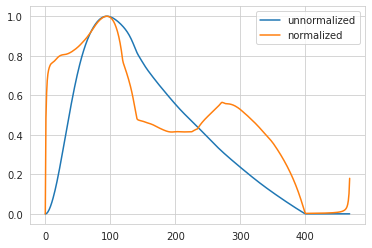

In [7]:
#normalize y
ys = data['y_train']
print(ys.shape)
ys_norm = np.zeros_like(ys)
#leave this to show that normalization for y isn't necessary
for i in range(ys.shape[1]):
    if (ys[:, i].max() - ys[:, i].min()) > 0:
        ys_norm[:, i] = (ys[:, i] - ys[:, i].min()) / (ys[:, i].max() - ys[:, i].min())
plt.plot(ys[0], label = 'unnormalized')
plt.plot(ys_norm[0], label = 'normalized')
plt.legend()
#get orignal values for y
#ys = torch.from_numpy(ys).float()

## Show the variation in the y measurements to see which part of the signal is most critical for solving the inverse problem.

max std in the data:  0.07615904282820499


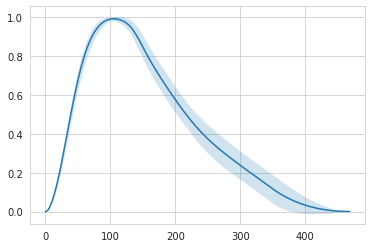

In [8]:
#we plot the mean as a function of time along with the standard deviation
timepoints = np.arange(ys.shape[1])
y_mean = ys.mean(axis=0)
y_std = ys.std(axis = 0)
print('max std in the data: ', np.max(y_std))
plt.plot(timepoints, y_mean, '-')
plt.fill_between(timepoints, y_mean - y_std, y_mean + y_std, alpha=0.2)

In [ ]:
#now we plot the mean sharp and every individual measument with higher opacity
plt.plot(timepoints, y_mean, '-', color = 'black', label = 'Mean')
for i in range(np.min([len(ys), 20000])):
    plt.plot(timepoints, ys[i], color = 'coral', alpha = 0.01)
plt.legend()
plt.show()

## Check if our data X is correlated. This will depend onthe prior that we are sampling from, so normally they shouldn't be correlated

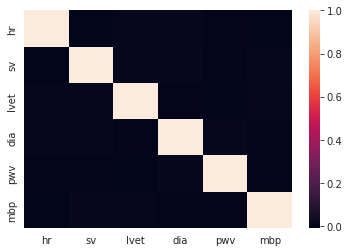

,hr,sv,lvet,dia,pwv,mbp
hr,1.0***,-0.01,0.0,0.0,-0.0,-0.01
sv,-0.01,1.0***,0.01,0.01*,-0.0,0.01
lvet,0.0,0.01,1.0***,-0.0,-0.01,0.01
dia,0.0,0.01*,-0.0,1.0***,0.01*,-0.0
pwv,-0.0,-0.0,-0.01,0.01*,1.0***,-0.0
mbp,-0.01,0.01,0.01,-0.0,-0.0,1.0***


In [6]:
%matplotlib inline
x_pd = pd.DataFrame(xs, columns=x_labels)

correlations = x_pd.corr()
sns.heatmap(correlations)
plt.show()

pval = x_pd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*correlations.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
correlations.round(2).astype(str) + p

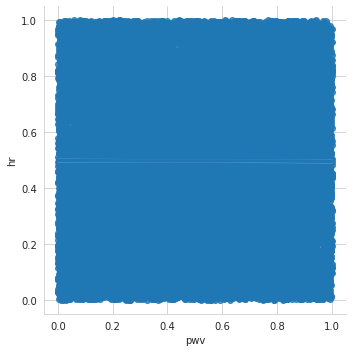

In [8]:
#I used this before because there was some slight correlation between these parameters
sns.lmplot(x = 'pwv', y = 'hr', data = x_pd, order = 1)

Text(0.5, 0, 'pwv')

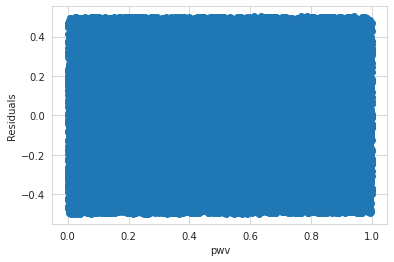

In [10]:
linreg = LinearRegression()
linreg.fit(x_pd['pwv'].values.reshape((-1,1)), x_pd['hr'])
y_pred = linreg.predict(x_pd['pwv'].values.reshape((-1,1)))
residuals = x_pd['hr']-y_pred
plt.scatter(y=residuals, x=x_pd['pwv'])
plt.ylabel('Residuals')
plt.xlabel('pwv')

/home/matthias/environments/master/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Residuals')

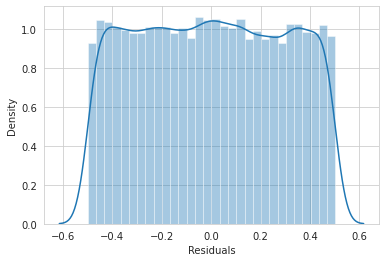

In [11]:
sns.distplot(residuals)
plt.xlabel('Residuals')

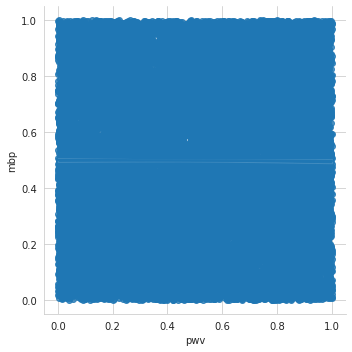

In [12]:
sns.lmplot(x = 'pwv', y = 'mbp', data = x_pd, order = 1)

Text(0.5, 0, 'pwv')

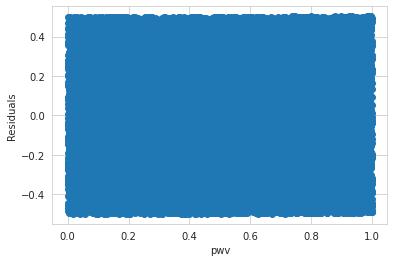

In [14]:
linreg = LinearRegression()
linreg.fit(x_pd['pwv'].values.reshape((-1,1)), x_pd['mbp'])
y_pred = linreg.predict(x_pd['pwv'].values.reshape((-1,1)))
residuals = x_pd['mbp']-y_pred
plt.scatter(y=residuals, x=x_pd['pwv'])
plt.ylabel('Residuals')
plt.xlabel('pwv')

/home/matthias/environments/master/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Residuals')

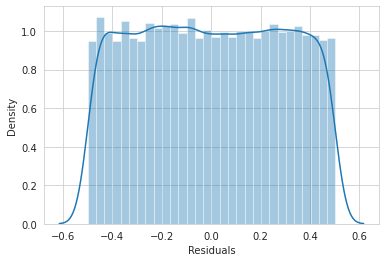

In [15]:
sns.distplot(residuals)
plt.xlabel('Residuals')

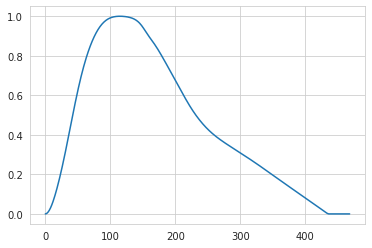

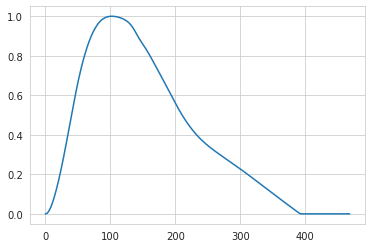

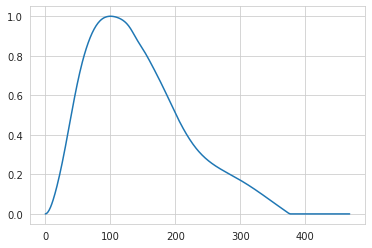

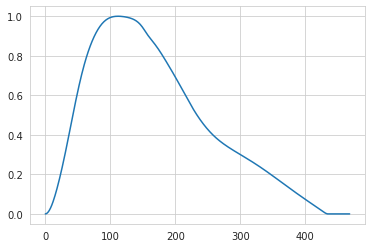

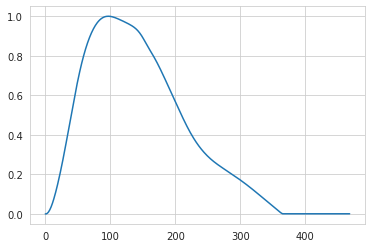

In [16]:
for i in range(5):
    plt.plot(ys[i])
    plt.show()


In [17]:
print(ys[:20,1])

[7.2493e-04 5.0910e-04 8.5917e-04 6.9313e-04 9.3814e-05 2.6639e-04
 2.3456e-05 5.0701e-04 5.3032e-06 8.6948e-04 6.0830e-04 3.7501e-04
 3.9931e-04 3.8662e-04 2.4283e-04 6.1102e-04 6.6731e-04 5.8097e-04
 4.1359e-04 2.4818e-04]


## Time-Series Analysis

We inspect the time-dependent nature of our dependent variable y, the PPG signal. First, let's have a look into the aut-correlation of the data.


(25000, 468, 7) (25000, 468, 1)


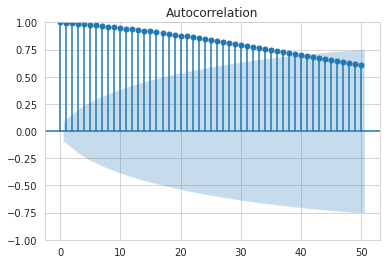

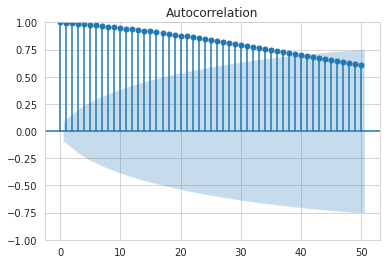

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import grangercausalitytests as gc
from statsmodels.tsa.api import VAR
import pandas as pd

def sequentialize(x,y):
    y_timeseries = y.reshape((-1,y.shape[1],1))
    x_timeseries = x.repeat(y.shape[1], axis=1).reshape((x.shape[0], y.shape[1], x.shape[1]))
    x_timeseries = np.concatenate((x_timeseries,y_timeseries), axis = 2)
    x_timeseries = x_timeseries[:,:-1,:]
    y_timeseries = y_timeseries[:,1:,:]

    return x_timeseries, y_timeseries

x,y = sequentialize(xs,ys)
print(x.shape, y.shape)
data_ts = pd.DataFrame(x[0], columns = x_labels + ['y_past'])
data_ts['y'] = y[0]
plot_acf(data_ts.y.to_list(), lags = 50)

In [ ]:
#construct a VAR model
model = VAR()